<center>
<h1>MCMC sans biais</h1>
BLAZER Alan, BOUVIER Oscar, DUPUY-ZINI Alexandre
</center>

------

Le but de ce projet est de mettre en œuvre la méthode de “débiaisage” de MCMC proposé dans l’article suivant: https://arxiv.org/abs/1708.03625.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sbs
from tqdm import tqdm
import pandas as pd
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import pickle

------

# Question 1

### Définition du problème

Tout d'abord, nous cherchons à mettre en œuvre le Gibbs sampler correspondant à l’exemple PUMP décrit [ici](http://www.openbugs.net/Examples/Pumps.html). L'exemple considéré est celui de la modélisation des défaillances de $p=10$ pompes d'une centrale, d'après George et al (1993). Les observations sont les suivantes :

Pump | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- 
**Time** | 94.3 | 15.7 | 62.9 | 126 | 5.24 | 31.4 | 1.05 | 1.05 | 2.1 | 10.5
**Failures** | 5 | 1 | 5 | 14 | 3 | 19 | 1 | 1 | 4 | 22

Le nombre de défaillances $(x_i)_p$ est supposé être iid de loi de Poisson définie par :

$$x_i \sim Poisson(\theta_i t_i)$$

avec $\theta_i$ le taux de panne de la pompe $i$ et $t_i$ le temps depuis lequel la pompe $i$ est opérationnelle.

Les taux de défaillance sont supposés iid et modélisés par la loi gamma suivante :

$$\theta_i \sim \Gamma(\alpha, \beta)$$

avec $\alpha$ et $\beta$ deux hyperparamètres choisis tels que :

$$\alpha \sim Exp(1.0)$$

$$\beta \sim \Gamma(0.1, 1.0)$$

$$\pi(\alpha, \beta)=\pi(\alpha)\pi(\beta)$$

Le principe du modèle est que bien qu'il considère que les pompes ne sont pas identiques ($\theta_i$ n'ont pas une valeur unique), elles possèdent tout de même des caractéristiques communes ($\alpha$ et $\beta$ qui sont partagés). Le modèle suppose donc que des informations sur une pompe peuvent être obtenus grace aux autres pompes.

In [2]:
t = [94.3, 15.7, 62.9, 126, 5.24, 31.4, 1.05, 1.05, 2.1, 10.5]
x = [5, 1, 5, 14, 3, 19, 1, 1, 4, 22]

### Simulation

D'après le modèle précédent, nous savons que :

$$P(x_i| \theta_i)=\frac{(\theta_i t_i)^{x_i}exp(-\theta_i t_i)}{x_i!}$$

$$P(\theta_i| \alpha, \beta)=\frac{\beta^\alpha}{\Gamma(\alpha)}\theta_i^{\alpha-1}exp(-\beta \theta_i)$$

Afin d'obtenir des estimations des paramètres du problème, nous avons besoin de faire des tirages selon leurs distributions. Nous pouvons simuler ces tirages grâce au Gibbs Sampling, qui retourne une MCMC dont les valeurs sont les tirages selon les postérieures, et utiliser des moyennes de ces tirages pour obtenir les estimations recherchées.

Pour appliquer le Gibbs Sampling, nous avons besoin des postérieures conditionnelles des $\theta_i$, ainsi que de $\alpha$ et $\beta$. Or, en rappelant que $Posterior\varpropto Likelihood*Prior$:

$$
\begin{align}
    \pi(\theta_i|\alpha,\beta,x_i) &\varpropto \pi(\theta_i|\alpha,\beta)\pi(x_i|\alpha,\beta,\theta_i)\\
    &\varpropto \pi(\theta_i|\alpha,\beta)\pi(x_i|\theta_i)\\
    &\varpropto exp(-(t_i+\beta)\theta_i)\theta_i^{\alpha+x_i-1}\\
    &\sim Gamma(\alpha+x_i, t_i+\beta)
\end{align}
$$

$$
\begin{align}
    \pi(\alpha,\beta|(\theta_i)_p) &\varpropto \prod P(\theta_i|\alpha,\beta)\pi(\alpha,\beta)\\
    &\varpropto \left(\frac{\beta^\alpha}{\Gamma(\alpha)}\right)^p\left(\prod\theta_i\right)^{\alpha-1}exp(-\beta \sum\theta_i)\pi(\alpha,\beta)\\
\end{align}
$$

D'où:

$$
\begin{align}
    \pi(\alpha|(\theta_i)_p,\beta) &\varpropto \left(\frac{\beta^\alpha}{\Gamma(\alpha)}\right)^p\left(\prod\theta_i\right)^{\alpha}\pi(\alpha)\\
\end{align}
$$

et:

$$
\begin{align}
    \pi(\beta|(\theta_i)_p,\alpha) &\varpropto \beta^{p\alpha}exp(-\beta \sum\theta_i)\pi(\beta)\\
    &\sim Gamma(p\alpha + 0.1, \sum(\theta_i) + 1)
\end{align}
$$

Les $\theta_i$ et $\beta$ sont facilement simulés, mais $\alpha$ ne présente pas une forme standard. De plus, il n'est pas possible de simuler $\alpha$ et $\beta$ simultanément car elles dépendent l'une de l'autre. Toutefois, il est possible de simuler $\alpha$ via une méthode d'acceptation-rejet, à partir des nouvelles valeurs de $\beta$ et des $\theta_i$.

### Acceptation rejet

Soient $f$ et $g$ deux densités de probabilité tels que $f\leq Mg$, avec $M \geq 1$. L'algorithme d'acceptation rejet est alors :


> Repeter
> $$X \sim g$$
> $$U \sim \mathbb{U}[0,1]$$
> Tant que
> $$U \geq \frac{f(X)}{Mg(X)}$$

L'objectif de cette méthode est de sampler depuis une distribution $f$ dont il n'est pas facile de faire des tirages. On choisit alors $g$ qui satisfait une condition de majoration de $f$ et dont les tirages sont plus simples. Les tirages de $g$ sont ensuite soumis à une règle de décision, qui permet d'affirmer s'ils peuvent être considérés comme des tirages de $f$ ou non. Le facteur $M$ est la probabilité d'acceptance.

### Application

Après avoir observé la distribution de nombreux tirages de la postérieure de $\alpha$, nous avons pu remarquer que peu de tirages se situaient au dessus de 2.5. Nous pouvons donc utiliser comme fonction $g$ la fonction de distribution de $\mathbb{U}[0,2.5]$.

Toutefois, après avoir appliqué cette méthode au problème, le sampling était extrement lent pour obtenir les tirages necessaires aux estimations de paramètres. En effet, la répartition est assez inégale entre 0 et 2.5, à l'inverse d'une loi uniforme.

Nous avons donc cherché à obtenir une meilleure fonction $g$ pour notre algorithme d'acceptation-rejet. En particulier, nous avons décidé d'utiliser une loi log-normale. Nous faisons en particulier les observations suivantes.

In [3]:
alphas = pickle.load(open("RWMH_simulated_alpha.pkl", "rb"))

/Users/alexandre/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/alexandre/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


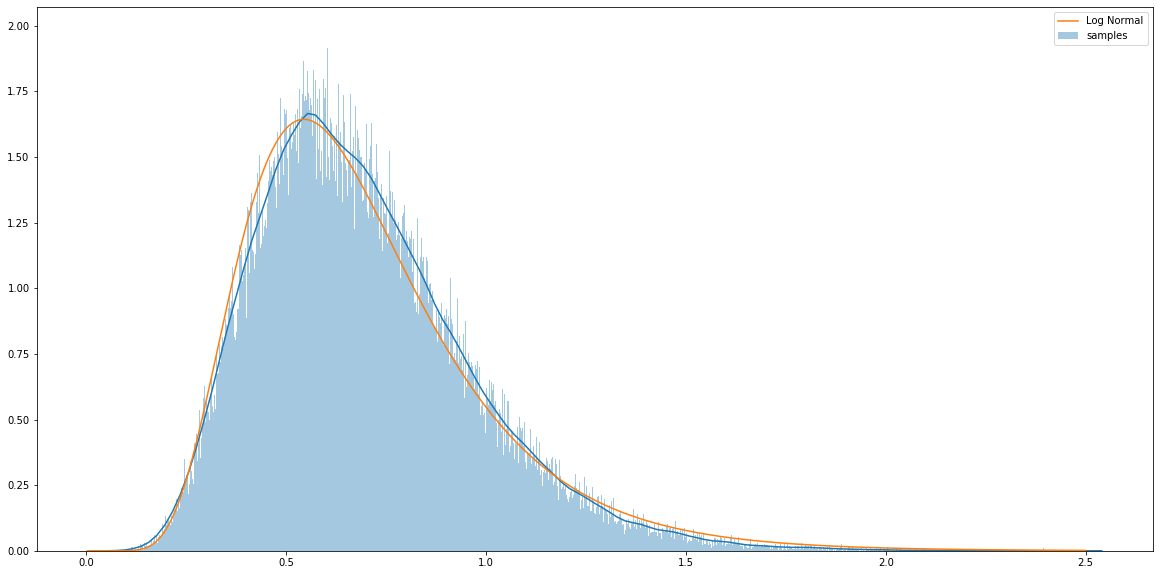

In [4]:
absc = np.linspace(0, 2.5, 1000)

def log_normal_density(x, mu, sigma):
     return np.exp(-(((np.log(x)-mu)/sigma)**2)/2)/(x*sigma*np.sqrt(2*np.pi))

plt.figure(figsize=(20, 10))
ax1 = sbs.distplot(alphas, bins=1000, label="samples")
val = [log_normal_density(y, -0.44, 0.41) for y in absc]
plt.plot(absc, val, label='Log Normal')
plt.legend()
plt.show()

In [5]:
fit = ax1.get_lines()[1].get_data()
xfit, yfit = fit[0], fit[1]

M=4
c = 0
for i in range(1, len(xfit[1:])):
    if yfit[i]/log_normal_density(xfit[i], -0.44, 0.39) > M:
        c += 1

print("Environ {0:.2%} des valeurs semblent ne pas convenir pour M={1}".format(c/len(xfit[1:]), M))

Environ 3.00% des valeurs semblent ne pas convenir pour M=4


Ainsi nous pouvons assumer que la loi log-normale définie est empiriquement valable pour l'algorithme d'acceptation-rejet.

Toutefois, nous avons remarqué qu'appliquer cet algorithme avec une loi log-normale, et appliquer un Random Walk Metropolis Hasting était assez similaire (à ordonnancement près des échantillons). Nous avons donc décidé de nous concentrer sur cette deuxième version de la résolution du problème d'estimation.

### Simulation à l'aide de RWMH


Comme $\alpha$ est contraint à être positif, et que par expérience nous avons pu rencontrer des valeurs négatives en samplant depuis une loi normale centrée sur $\alpha_{t-1}$, nous allons donc sampler $\alpha$ depuis une loi log-normale. Ainsi, aucune valeur négative ne peut être tirée, et on conserve le principe d'une marche aléatoire.

Les paramètres de notre simulation sont les suivants :
* 15000 itérations
* burn-in de 3000 itérations (cette valeur a été fixée très large pour être moins dépendant de l'état initial, d'après les traces de $\alpha$ et $\beta$ obtenues après)
* $\alpha$ et $\beta$ sont initialisés aléatoirement selon leur prieure

In [6]:
class Pump:

    def __init__(self):
        self.N = 15000 #Markov chain length
        self.burnin = 3000
        self.alpha = [np.random.exponential(scale=1)]
        self.beta = [np.random.gamma(shape=0.1, scale=1)]
        self.theta = [[np.random.gamma(shape=self.alpha[-1], scale=1/self.beta[-1]) for i in range(10)]]
        self.sd = 0.8 #standard deviation for Metropolis Hasting kernel
        self.acceptance_rate = 0
        self.p = 10

    def gibbs(self, x, t):
        for k in tqdm(range(self.N)):
            current_theta = self.theta[-1]
            current_alpha = self.alpha[-1]
            current_beta = self.beta[-1]

            new_theta = []

            for i in range(self.p):
                new_theta.append(np.random.gamma(shape = x[i] + current_alpha, scale = 1/(t[i] + current_beta)))

            new_beta = np.random.gamma( shape = self.p * current_alpha + 0.1, scale = 1/(np.sum(new_theta) + 1))

            self.beta.append(new_beta)
            self.theta.append(new_theta)
            self.alpha.append(self.update_alpha(current_alpha, new_beta, new_theta))
        
    def update_alpha(self, current_alpha, new_beta, new_theta):
        alpha_star = np.random.lognormal(mean=np.log(current_alpha)-0.5*self.sd**2, sigma=self.sd)
        
        f_star = self.alpha_density(alpha_star, new_beta, new_theta) * self.log_normal_density(current_alpha, np.log(alpha_star)-0.5*self.sd**2, self.sd)
        f_k = self.alpha_density(current_alpha, new_beta, new_theta) * self.log_normal_density(alpha_star, np.log(current_alpha)-0.5*self.sd**2, self.sd)

        prob =  min(1,f_star/f_k)

        if np.random.uniform() < prob :
            self.acceptance_rate += 1
            return(alpha_star)
        else :
            return(current_alpha)

    def log_normal_density(self, x, mu, sigma):
        return np.exp(-(((np.log(x)-mu)/sigma)**2)/2)/(x*sigma*np.sqrt(2*np.pi))
    
    def alpha_density(self, alph, bet, thet):
        return np.exp(-alph + self.p * (alph* np.log(bet) - np.log(math.gamma(alph)))+(alph-1)*np.sum(np.log(thet)))

In [7]:
model = Pump()
model.gibbs(x, t)

print("Le taux d'acceptance de alpha est de {0:.2%}".format(model.acceptance_rate/model.N))

100%|██████████| 15000/15000 [00:01<00:00, 8302.66it/s]

Le taux d'acceptance de alpha est de 31.97%


Ce taux d'acceptance est convenable et recherché.

En effet, nous fixons volontairement la standard deviation à 0.8 afin, d'une part, de réduire les valeurs prises par la fonction d'autocorrélation. En outre, nous souhaitons que cette standard deviation soit suffisamment élevée pour que les valeurs possibles de la loi cible soient correctement balayées par notre modèle.

Il s'agit donc d'effectuer un arbitrage entre le balayage des valeurs de la loi cible et l'intensité des autocorrélations. En choisissant ce paramètre à 0.8, nous minimisons les autocorrélations tout en conservant un balayage très pertinent des valeurs possibles de la loi cible.

Les analyses des résultats ci-dessous viennent renforcer ces affirmations.

### Analyse des résultats

In [8]:
def stats(param, burnin):
    mean = np.mean(param[burnin:], axis=0)
    sd = np.sqrt(np.var(param[burnin:], axis=0))
    median = np.median(param[burnin:], axis=0)
    return {"mean":mean, "sd":sd, "median":median}

def plot_trace(param):
    plt.figure(figsize=(20,10))
    plt.scatter(np.arange(0,len(param),1), param, s=0.1)
    plt.title('trace')
    plt.show()

def acf_first_non_sign(param):
    coeff_autocorr = abs(sm.tsa.stattools.acf(pd.DataFrame(param)[0].tolist(), nlags = 200)).tolist()
    B = pd.Series(coeff_autocorr)
    C = (B ** 2).cumsum()
    first_coeff_non_signif = int(B.apply(lambda x: x <= 1.96*np.sqrt((1/len(pd.DataFrame(param)[0].tolist()))* (1 + 2*C[coeff_autocorr.index(x)]))).tolist().index(True))
    return(first_coeff_non_signif)
    
def acf(param):  
    fig, axs = plt.subplots(2, 1, figsize=(20,10))
    sm.graphics.tsa.plot_acf(param, lags=range(acf_first_non_sign(param) + 10), ax = axs[0])
    sm.graphics.tsa.plot_acf(param, lags=range(acf_first_non_sign(param) - 5, acf_first_non_sign(param) + 5), ax = axs[1])
    plt.show()

#### Tableau des résultats

In [9]:
theta_stats = stats(model.theta, model.burnin)
alpha_stats = stats(model.alpha, model.burnin)
beta_stats = stats(model.beta, model.burnin)

In [10]:
data = [alpha_stats, beta_stats]
for i in range(model.p):
    theta = {}
    for key in theta_stats.keys():
        theta[key] = theta_stats[key][i]
    data.append(theta)

index = ['alpha', 'beta', 'theta_1', 'theta_2','theta_3','theta_4','theta_5','theta_6','theta_7','theta_8' ,'theta_9','theta_10']

pd.DataFrame(data, index=index)

,mean,sd,median
alpha,0.707885,0.267211,0.674378
beta,0.945731,0.544701,0.845360
theta_1,0.059575,0.025204,0.056226
theta_2,0.101776,0.079875,0.082482
theta_3,0.089321,0.037136,0.084009
theta_4,0.116068,0.030144,0.113775
theta_5,0.599486,0.318893,0.544281
theta_6,0.610565,0.137375,0.599723
theta_7,0.887754,0.722000,0.704909
theta_8,0.890835,0.722785,0.709628


Ce tableau de valeur présente des résultats très similaires aux valeurs décrite dans l'exemple PUMP cité plus haut.

#### Alpha

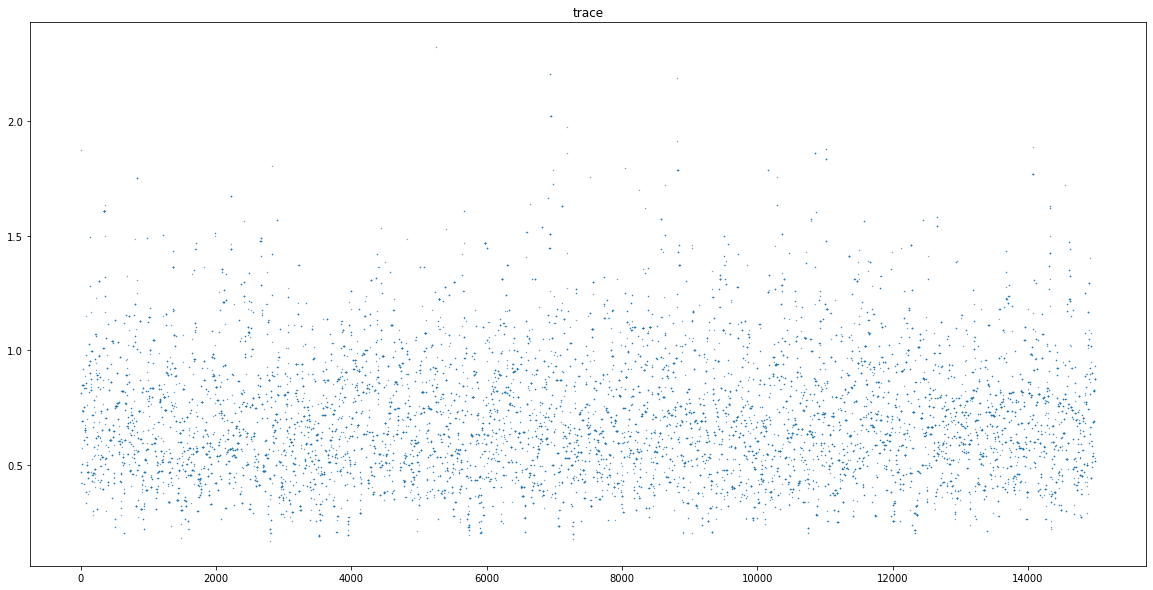

In [11]:
plot_trace(model.alpha)

/Users/alexandre/.pyenv/versions/3.6.9/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


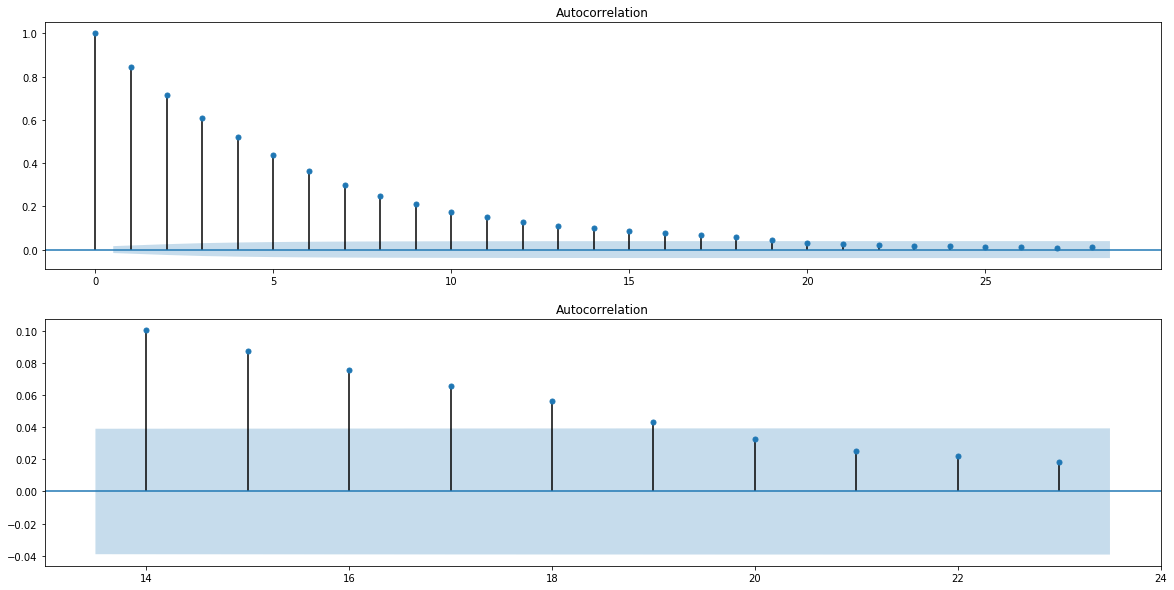

In [12]:
acf(model.alpha)

La trace est satisfaisante. En effet, d'une part sa trajectoire semble aléatoire et, d'autre part, la chaîne explore bien la loi cible. La trace indique donc le bon balayage des valeurs possibles d'alpha.

En revanche, et les graphiques précédents en attestent, des corrélations persistent entre $X_{n,0}$ et $X_{n+k,0}$ pour k pouvant aller jusqu'à 20.

#### Beta

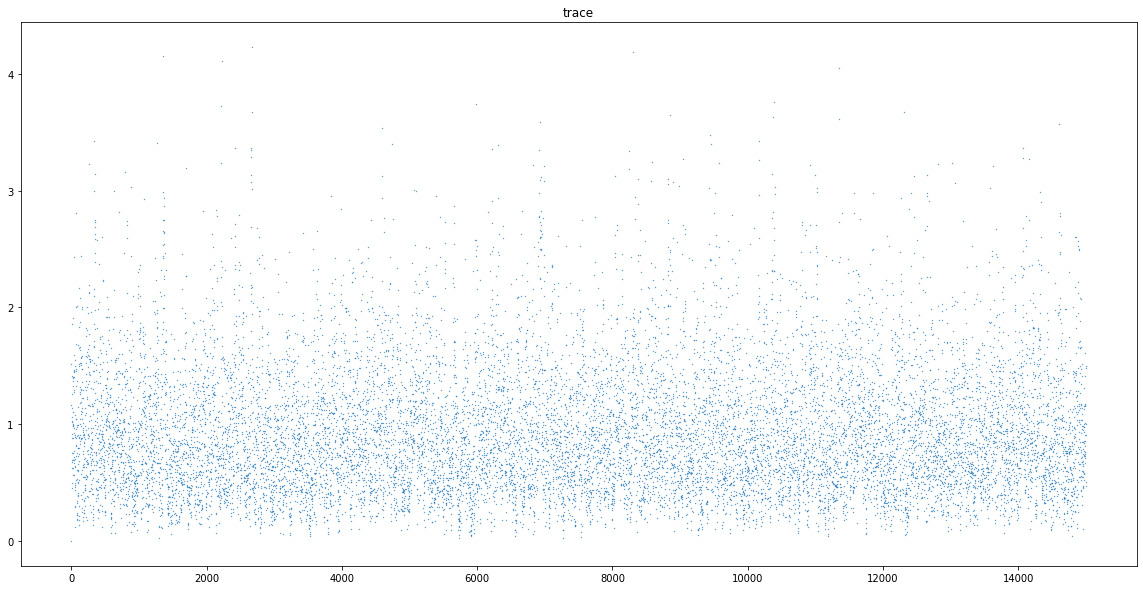

In [13]:
plot_trace(model.beta)

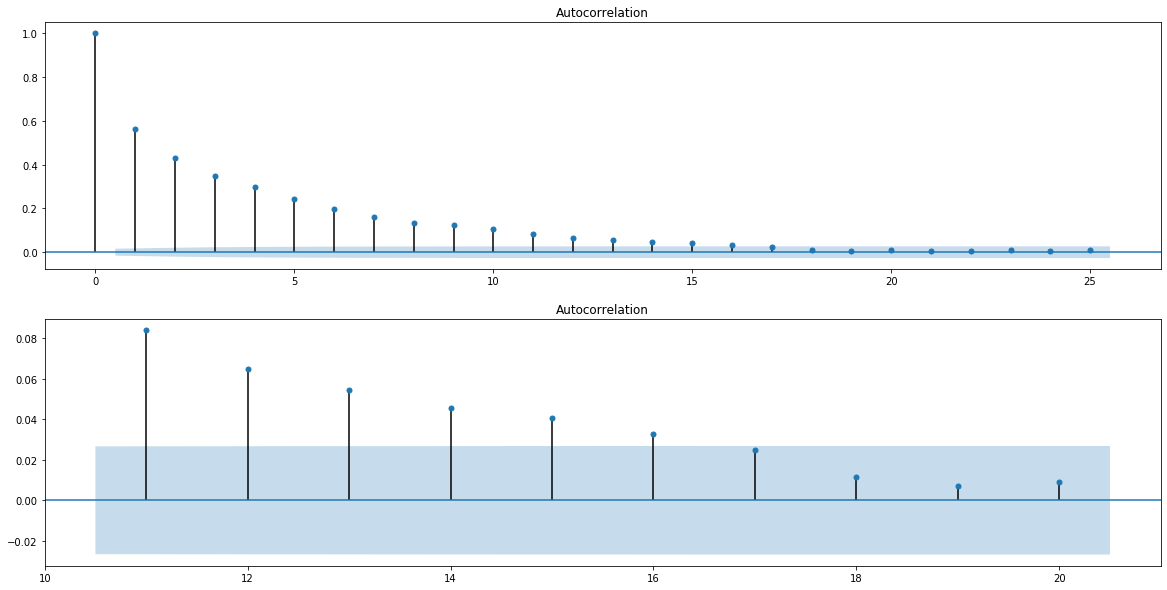

In [14]:
acf(model.beta)

Les constatations concernant $\beta$ sont les mêmes. On précise ici que les coefficients d'autocorrélation cessent d'être significatifs à partir de k = 20.

-----

# Question 2

Tout d'abord, nous allons étudier la technique du maximal coupling expliquée dans cet [article](https://arxiv.org/abs/1708.03625), en comparaison à la méthode d'acceptation-rejet.

### Maximal coupling

Soient $p$ et $q$ deux densités de probabilité. L'algorithme est alors

> $$X \sim p$$ puis $$W|X \sim \mathbb{U}[0,p(X)]$$ <br/>
>> Si $W < q(X)$, retourner $$(X,X)$$ <br/>
> Sinon répéter $$Y^* \sim q$$ puis $$W^*|Y^* \sim \mathbb{U}[0,q(Y^*)]$$
> Tant que $$W^* \leq p(Y^*)$$
> Puis retourner $$(X,Y^*)$$


Pour deux lois indépendantes, on a $(x,y) \mapsto \bar{\pi}(x,y)=p(x)q(y)$. Mais pour des lois de coupling maximal, on a $(X,Y) \sim \bar{\pi}$ avec une probabilité maximale d'être identiques, c'est-à-dire $P(X=Y)$ est maximal sous les contraintes $X \sim p$ et $Y\sim q$. $p$ et $q$ sont donc les lois marginales de la loi jointe $\bar{\pi}$, et on suppose que le cas $X=Y$ fait sens pour notre application, c'est-à-dire que les deux lois sont des distributions sur le même espace.

La possibilité que des issues de ces deux lois soient identiques résulte de l'intuition suivante : si $X \sim p$, et que $q(X)>0$, alors ce tirage de X pourrait aussi avoir été tiré selon $q$. L'algorithme précédent donne des couples $(X,Y)$ qui respectent cette propriété.

On peut voir cet algorithme comme une méthode d'acceptation-rejet "réciproque", puis qu'elle s'applique aux deux lois, et non plus seulement au sampling selon $f$. Les tirages de couples de valeurs identiques sont également plus probables que si les lois étaient indépendantes.

### Mise en oeuvre pour les variables aléatoires du problème prédécent

Ici nous appliquons la méthode de maximal coupling pour deux lois gammas, deux lois normales et deux lois exponentielles, pour illustrer par l'exemple.

In [15]:
def gamma_density(x, shape, scale):
     return (np.exp(- x/scale) * x**(shape-1) * 1/scale ** shape) / math.gamma(shape)
    
def exp_density(x, l):
     return l*np.exp(- l * x)

def log_normal_density(x, mu, sigma):
    return np.exp(-(((np.log(x)-mu)/sigma)**2)/2)/(x*sigma*np.sqrt(2*np.pi))
    
def maximal_gamma_coupled(shape1, scale1, shape2, scale2):
    x = np.random.gamma(shape1, scale1)
    if (np.random.uniform()*gamma_density(x, shape1, scale1) < gamma_density(x, shape2, scale2)):
        return [x,x]
    else:
        while True:
            y = np.random.gamma(shape2, scale2)
            W = np.random.uniform() * gamma_density(y, shape2, scale2)
            if W > gamma_density(y, shape1, scale1):
                return [x,y]
            
def maximal_log_normal_coupled(mu1, s1, mu2, s2):
    x = np.random.lognormal(mean=mu1, sigma=s1)
    if (np.random.uniform()*log_normal_density(x, mu1, s1) < log_normal_density(x, mu2, s2)):
        return [x,x]
    else:
        while True:
            y = np.random.lognormal(mean=mu2, sigma=s2)
            W = np.random.uniform() * log_normal_density(y, mu2, s2)
            if W > log_normal_density(y, mu1, s1):
                return [x,y]

def maximal_exp_coupled(l1, l2):
    x = np.random.exponential(1/l1)
    if (np.random.uniform()*exp_density(x, l1) < exp_density(x, l2)):
        return [x,x]
    else:
        while True:
            y = np.random.exponential(1/l2)
            W = np.random.uniform() * exp_density(y, l2)
            if W > exp_density(y, l1):
                return [x,y]

def plot_maximal_coupled(option):
    X, Y = [], []
    if option == "gamma":
        x_max = 40        
        density1 = lambda x: gamma_density(x, shape1, scale1)
        density2 = lambda x: gamma_density(x, shape2, scale2)
        coupled = lambda: maximal_gamma_coupled(shape1, scale1, shape2, scale2)

    elif option == "exp":
        x_max = 10
        density1 = lambda x: exp_density(x, l1)
        density2 = lambda x: exp_density(x, l2)
        coupled = lambda: maximal_exp_coupled(l1, l2)
    
    elif option == "log_normal":
        x_max = 4
        density1 = lambda x: log_normal_density(x, mu1, s1)
        density2 = lambda x: log_normal_density(x, mu2, s2)
        coupled = lambda: maximal_log_normal_coupled(mu1, s1, mu2, s2)
    
    absc = np.linspace(0, x_max, 5000)
    y_1 = [density1(x) for x in absc]
    y_2 = [density2(x) for x in absc]
    
    for i in tqdm(range(5000)):
        couple = coupled()
        X.append(couple[0])
        Y.append(couple[1])
        
    nb_x_x = (pd.Series(X) == pd.Series(Y)).sum()
    pct = nb_x_x/len(X)
    
    plt.figure(figsize=(20,10))
    plt.plot(absc, y_1)
    plt.plot(absc, y_2)
    sbs.distplot(X, kde=False, norm_hist=True)
    sbs.distplot(Y, kde=False, norm_hist=True)
    sbs.jointplot(x=X, y=Y, kind='scatter', space = 0.3)
    plt.plot()
    
    print("Le nombre de points présents sur la première bissectrice du plan s'élève à {0}, soit {1:.2%} du nombre total de points simulés".format(nb_x_x, pct))

### Visualisation

#### Gamma

In [16]:
shape1 = 2 #p
scale1 = 2
shape2 = 4 #q
scale2 = 4

100%|██████████| 5000/5000 [00:00<00:00, 35920.78it/s]


Le nombre de points présents sur la première bissectrice du plan s'élève à 1156, soit 23.12% du nombre total de points simulés


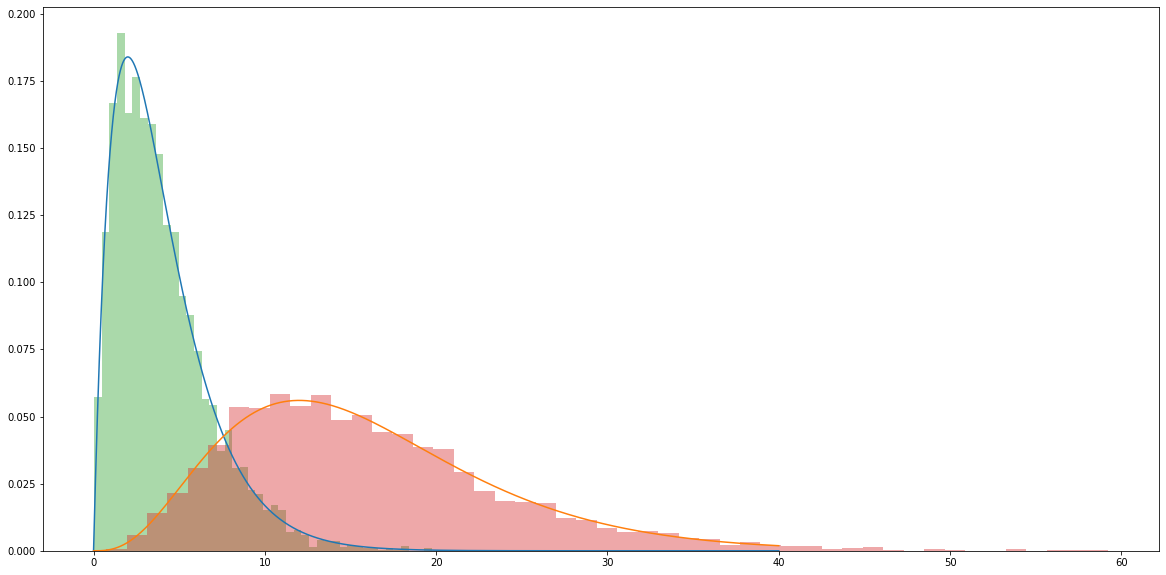

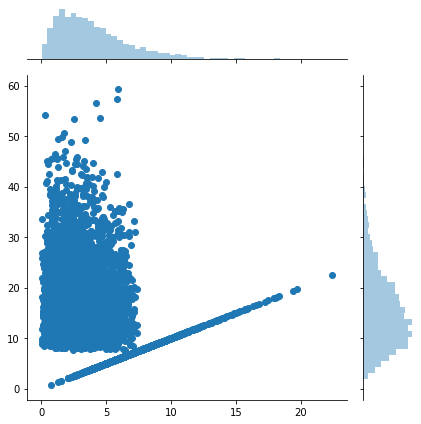

In [17]:
plot_maximal_coupled("gamma")

#### Log Normal

In [18]:
mu1=0.3
s1=0.1
mu2=0.5
s2=0.2

/Users/alexandre/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/alexandre/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
100%|██████████| 5000/5000 [00:00<00:00, 27978.25it/s]


Le nombre de points présents sur la première bissectrice du plan s'élève à 2217, soit 44.34% du nombre total de points simulés


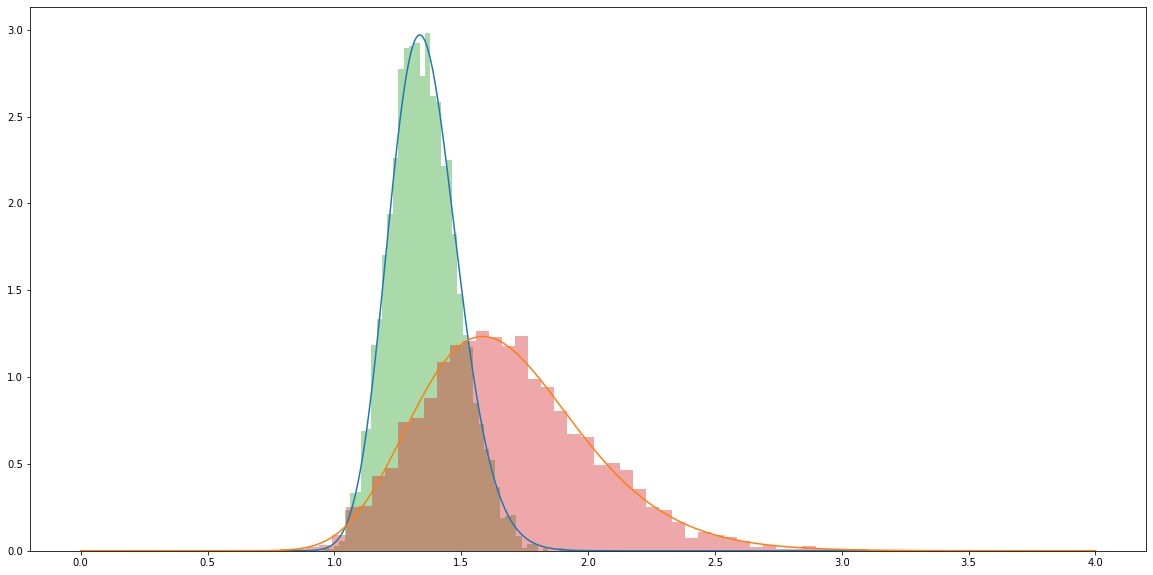

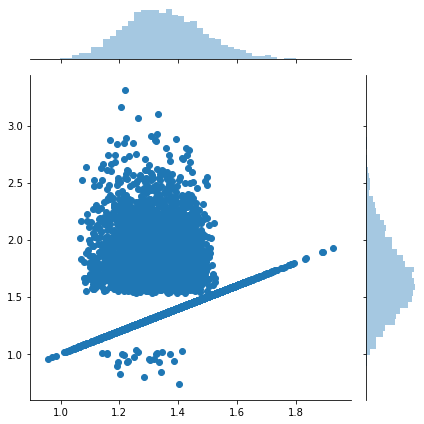

In [19]:
plot_maximal_coupled("log_normal")

#### Exponentielle

In [20]:
l1 = 0.5
l2 = 1.5

100%|██████████| 5000/5000 [00:00<00:00, 59237.73it/s]


Le nombre de points présents sur la première bissectrice du plan s'élève à 3074, soit 61.48% du nombre total de points simulés


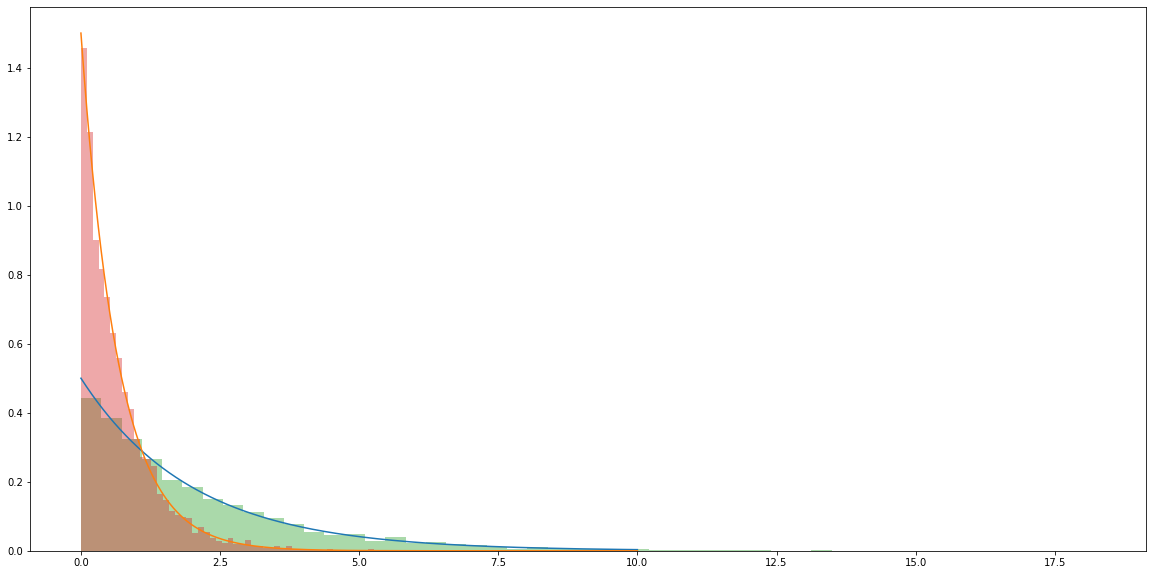

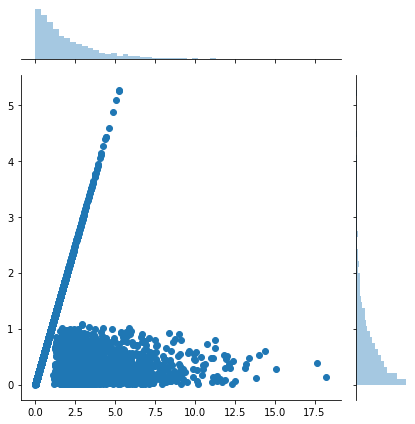

In [21]:
plot_maximal_coupled("exp")

Pour chacunes des lois, on observe bien que les distributions sont semblables aux distributions théoriques des lois simulées.

Nous constatons en revanche que la "répartition" des points est différente dans l'espace. Elle paraît réordonnée dans l'objectif de maximiser les cas d'égalité entre les deux tirages des lois marginales.

----

# Question 3

Le biais d'une MCMC dépend de son initialisation aléatoire, et la méthode précédente permet de l'éliminer. Ainsi on peut avoir en plus de la convergence vers la vraie valeur estimée qu'offrent les méthodes MCMC, une méthode y arrivant sans biais.

L'objectif n'est alors plus de prendre une MCMC très longue pour espérer avoir atteinds un état stationnaire, mais bien d'avoir de multiples MCMC plus courtes, qui indépendemment ont du biais, mais pas collectivement d'après la méthode évoquée.

Nous allons donc l'appliquer au Gibbs Sampling de l'exemple Pump introduit à la question 1, puis nous étudierons l'influence des paramètres du time_averaged_estimator.

#### Application au problème Pump

In [22]:
class UnbiaisedPump:

    def __init__(self, N, burnin, x, t, silent=False):
        self.N = N #Markov chain length
        self.burnin = burnin
        self.x = x
        self.t = t
        self.p = 10
        self.sd = 0.8 #standard deviation for Metropolis Hasting kernel
        self.acceptance_rate = [0, 0]
        self.alpha, self.beta, self.theta = self.random_init()
        self.meeting_time = 0
        self.silent = silent

    def random_init(self):
        alpha_X0 = np.random.exponential(scale=1)
        beta_X0 = np.random.gamma(shape=0.1, scale=1)
        theta_X0 = [np.random.gamma(alpha_X0, 1/beta_X0) for i in range(10)]
        
        theta_X1 = [np.random.gamma(alpha_X0 + self.x[i], 1/(beta_X0 + self.t[i])) for i in range(10)]
        beta_X1 = np.random.gamma( shape = self.p * alpha_X0 + 0.1, scale = 1/(np.sum(theta_X0) + 1))
        alpha_X1 = self.update_alpha_coupled([alpha_X0], [beta_X1], [theta_X1])[0]
        
        alpha_Y0 = np.random.exponential(scale=1)
        beta_Y0 = np.random.gamma(shape=0.1, scale=1)
        theta_Y0 = [np.random.gamma(alpha_Y0, 1/beta_Y0) for i in range(10)]
        
        return [[alpha_X1, alpha_Y0]], [[beta_X1, beta_Y0]], [[[theta_X1[i], theta_Y0[i]] for i in range(10)]]
        
    def gibbs_coupled(self):
        for k in tqdm(range(self.N), disable=self.silent):
            current_thetaX = [self.theta[-1][i][0] for i in range(10)]
            current_thetaY = [self.theta[-1][i][1] for i in range(10)]
            current_betaX = self.beta[-1][0]
            current_betaY = self.beta[-1][1]
            current_alphaX = self.alpha[-1][0]
            current_alphaY = self.alpha[-1][1]
            
            new_theta = []
            for i in range(self.p):
                theta_shapeX = current_alphaX + x[i]
                theta_shapeY = current_alphaY + x[i]
                theta_scaleX = 1/(current_betaX + t[i])
                theta_scaleY = 1/(current_betaY + t[i])
                new_theta.append(maximal_gamma_coupled(theta_shapeX, theta_scaleX, theta_shapeY, theta_scaleY))

            self.theta.append(new_theta)
            new_thetaX = [self.theta[-1][i][0] for i in range(10)]
            new_thetaY = [self.theta[-1][i][1] for i in range(10)]
            
            beta_shapeX = self.p * current_alphaX + 0.1
            beta_shapeY = self.p * current_alphaY + 0.1
            beta_scaleX = 1/(1 + np.sum(new_thetaX))
            beta_scaleY = 1/(1 + np.sum(new_thetaY))

            new_beta = maximal_gamma_coupled(beta_shapeX, beta_scaleX, beta_shapeY, beta_scaleY)
            new_alpha = self.update_alpha_coupled(self.alpha[-1], new_beta, [new_thetaX, new_thetaY])
                        
            self.beta.append(new_beta)
            self.alpha.append(new_alpha)
            
            if not self.equal_chains(new_alpha, new_beta, new_theta):
                self.meeting_time += 1
            
    def update_alpha_coupled(self, alphas, new_beta, new_theta):
        if len(alphas)>1:
            flag = True
            while flag:
                new_alphas = maximal_log_normal_coupled(np.log(alphas[0]) - 0.5*self.sd**2, self.sd, np.log(alphas[1]) - 0.5*self.sd**2, self.sd)
                if (new_alphas[0]>0 and new_alphas[1]>0):
                    flag = False
        else:
            new_alphas = [np.random.lognormal(mean = np.log(alphas[0]) - 0.5*self.sd**2, sigma = self.sd)]
        
        u = np.random.uniform()
        
        for i in range(len(alphas)):
            f_star = self.alpha_density(new_alphas[i], new_beta[i], new_theta[i]) * self.log_normal_density(alphas[i], np.log(new_alphas[i])-0.5*self.sd**2, self.sd)
            f_k = self.alpha_density(alphas[i], new_beta[i], new_theta[i]) * self.log_normal_density(new_alphas[i], np.log(alphas[i])-0.5*self.sd**2, self.sd)

            if u < min(1,f_star/f_k) :
                self.acceptance_rate[i] += 1
            else :
                new_alphas[i] = alphas[i]
        return new_alphas

    def log_normal_density(self, x, mu, sigma):
        return np.exp(-(((np.log(x)-mu)/sigma)**2)/2)/(x*sigma*np.sqrt(2*np.pi))

    def alpha_density(self, alph, bet, thet):
        return np.exp(-alph + self.p * (alph* np.log(bet) - np.log(math.gamma(alph)))+(alph-1)*np.sum(np.log(thet)))
    
    def equal_chains(self, new_alpha, new_beta, new_theta):
        theta1 = [new_theta[l][0] for l in range(10)]
        theta2 = [new_theta[l][1] for l in range(10)]
        return (theta1 == theta2 and new_beta[0] == new_beta[1] and new_alpha[0] == new_alpha[1])
    
    def time_averaged_estimator(self, X, Y, k, m):
        avg = 0
        for l in range(k, m+1):
            avg += X[l]
        
        bias_correction = 0
        for l in range(k+1, self.meeting_time):
            coeff = min(1, (l-k)/(m-k+1))
            bias_correction += coeff * (X[l] - Y[l])
        return avg/(m-k+1) + bias_correction
    
    def time_averaged_estimations(self, k, m):
        alpha_ta = self.time_averaged_estimator([x[0] for x in self.alpha[self.burnin:]], [x[1] for x in self.alpha[self.burnin:]], k, m)
        beta_ta = self.time_averaged_estimator([x[0] for x in self.beta[self.burnin:]], [x[1] for x in self.beta[self.burnin:]], k, m)
        theta_ta = []
        for i in range(self.p):
            theta_i_X = [thetas_i[i][0] for thetas_i in self.theta[self.burnin:]]
            theta_i_Y = [thetas_i[i][1] for thetas_i in self.theta[self.burnin:]]
            theta_ta.append(self.time_averaged_estimator(theta_i_X, theta_i_Y, k, m))
        return [alpha_ta, beta_ta, theta_ta]

In [23]:
model = UnbiaisedPump(N=5000, burnin=0, x=x, t=t)
model.gibbs_coupled()

print("Le meeting_time est {}".format(model.meeting_time))
print("Les taux d'acceptance des alphas sont de {0:.2%} pour X et {0:.2%} pour Y".format(model.acceptance_rate[0]/model.N, model.acceptance_rate[1]/model.N))

100%|██████████| 5000/5000 [00:01<00:00, 3204.39it/s]

Le meeting_time est 32
Les taux d'acceptance des alphas sont de 33.12% pour X et 33.12% pour Y


A chaque execution, nous obtenons des meeting_time assez faibles (moins de 20 en général), ceci étant un résultat attendu de la méthode de maximal coupling.

Les taux d'acceptances sont bons, les valeurs sont bien mélangées.

### Analyse des résultats

In [24]:
def plot_coupled_trace(param, meeting_time):
    plt.figure(figsize=(20,10))
    X = [x[0] for x in param[:meeting_time +10]]
    Y = [x[1] for x in param[:meeting_time +10]]
    absc = np.arange(0, len(X) ,1)
    plt.plot(absc, X)
    plt.plot(absc, Y)
    plt.title('trace')
    plt.show()

def acf_coupled(param): #Only plots for the first MCMC
    parametre = pd.DataFrame(param)[0].tolist()
    fig, axs = plt.subplots(2, 1, figsize=(20,10))
    sm.graphics.tsa.plot_acf(parametre, lags=range(acf_first_non_sign(parametre) + 10), ax = axs[0])
    sm.graphics.tsa.plot_acf(parametre, lags=range(acf_first_non_sign(parametre) - 5, acf_first_non_sign(parametre) + 5), ax = axs[1])
    plt.show()

In [25]:
res = model.time_averaged_estimations(0, model.N)
print("alpha =", res[0])
print("beta =", res[1])
print("theta =", res[2])

alpha = 0.6674059109491021
beta = 0.8731508578101024
theta = [0.058907989857698816, 0.1000577050620509, 0.0894648664224532, 0.1154758029661194, 0.6058968547261593, 0.6127577991011413, 0.9159188136317811, 0.9154321603473735, 1.608580216200849, 1.9911150504055843]


Les estimations sont similaires à celles obtenues à la question 1, mais cette fois avec une MCMC beaucoup plus courte (quelques centaines d'itérations pouvant être très suffisantes).

Tracer les traces complètes résulte au même constat que dans la question 1. Nous nous concentrons plutôt sur les effets de la méthode de maximal coupling pour les deux traces suivantes.

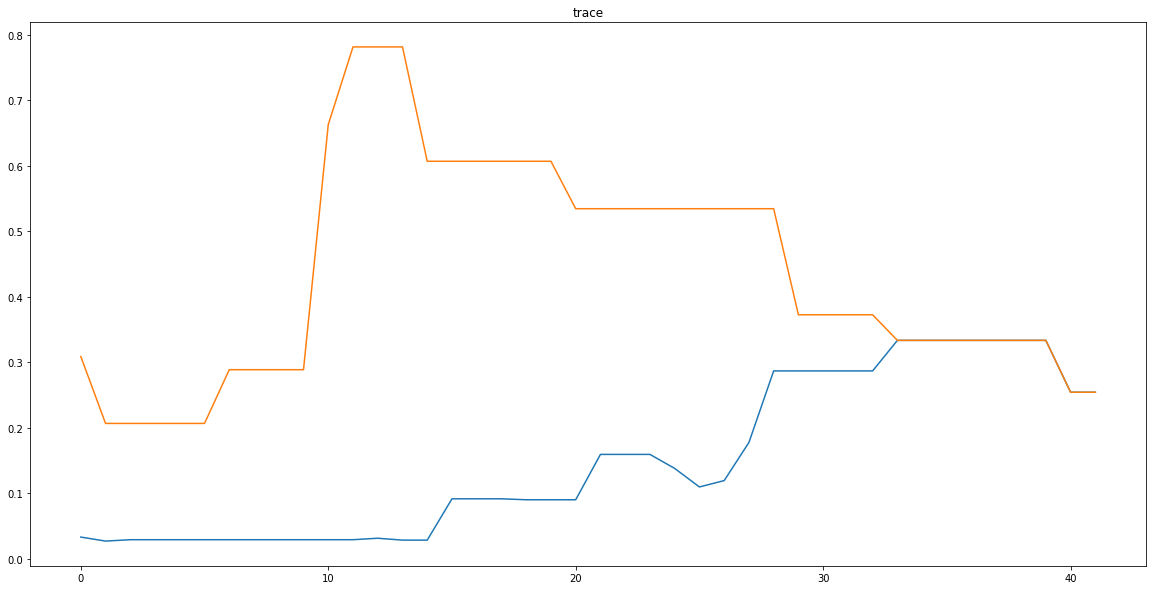

In [26]:
plot_coupled_trace(model.alpha, model.meeting_time)

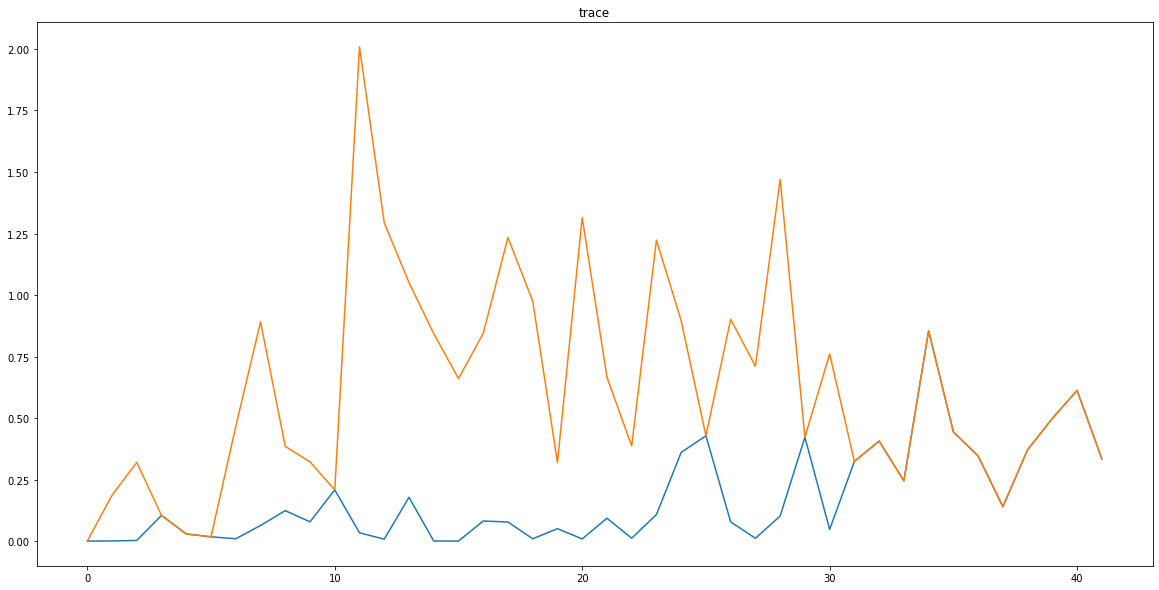

In [27]:
plot_coupled_trace(model.beta, model.meeting_time)

Nous pouvons observer qu'à partir du temps de rencontre de toutes les MCMC en même temps, elles conservent cette propriété d'égalité entre elles. On peut également remarquer que tant que ce meeting_time n'est pas atteint, certaines MCMC couplées peuvent être égale, puis se séparer de nouveau.

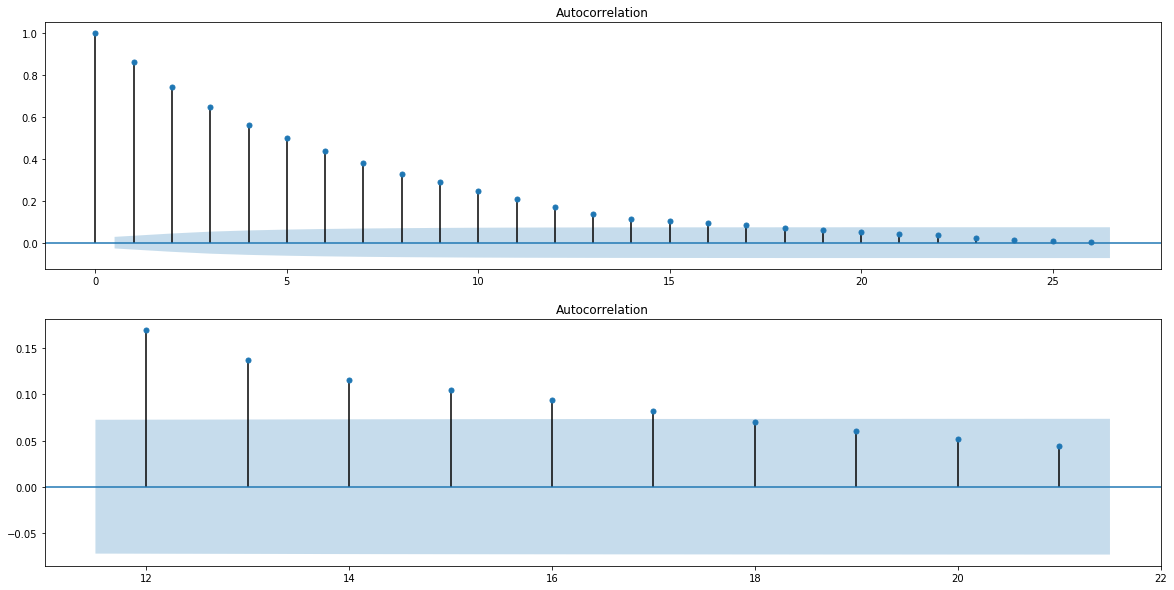

In [28]:
acf_coupled(model.alpha)

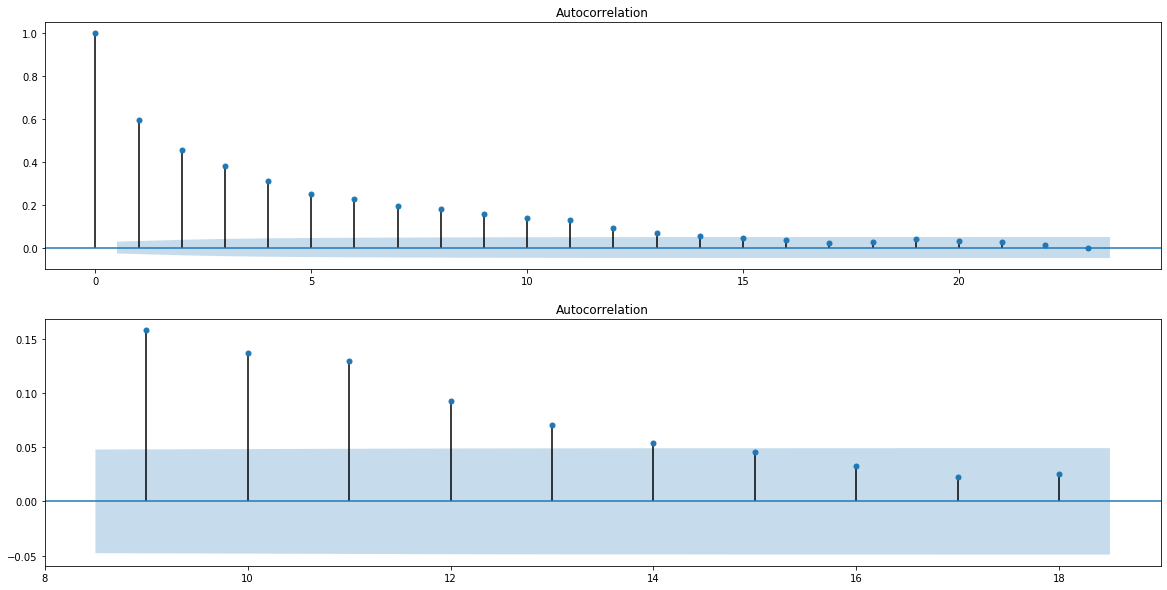

In [29]:
acf_coupled(model.beta)

On rappelle ici que les deux chaînes se rejoignant très rapidement, pour tracer les graphiques ACF, nous pouvons choisir indifféremment l'une et l'autre chaîne parmi les deux chaînes couplées. Dans la fonction acf_coupled définie plus haut, nous avons donc choisi les chaînes alpha_X1 et beta_X1.

En outre, on remarque une nette baisse des coefficients d'autocorrélation, à laquelle s'ajoute le fait que ces coefficients ne sont plus significatifs dès k < 20. On obtient donc un meilleur calibrage du modèle.

#### Répartition des meeting_time

In [30]:
def hist_unbiaised_pump_mt(N, burnin):
    mt = []
    for i in tqdm(range(1000)):
        model = UnbiaisedPump(N=N, burnin=burnin, x=x, t=t, silent=True)
        model.gibbs_coupled()
        mt.append(model.meeting_time)
        
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    plt.title('Distribution des meeting times')
    plt.xlabel('Meeting time')
    plt.hist(mt, bins=range(0, 80, 4), align = 'mid', color = 'navy')
    plt.show()

100%|██████████| 1000/1000 [00:46<00:00, 21.69it/s]


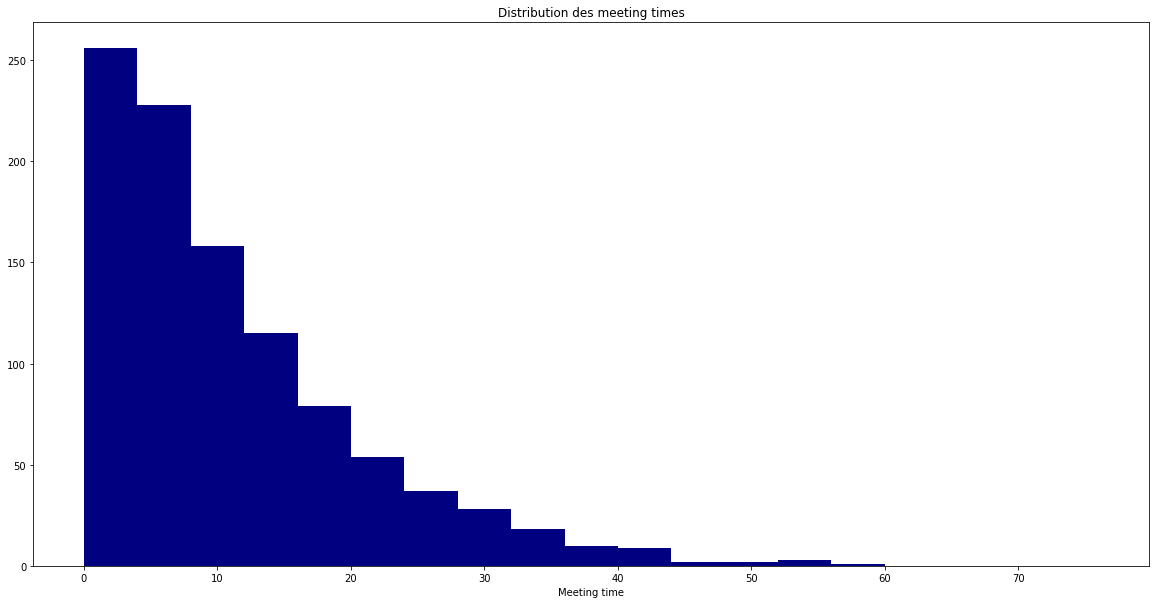

In [31]:
hist_unbiaised_pump_mt(N=150, burnin=0)

On remarque que les meeting times surviennent très tôt, et nous pouvons donc, comme souhaité, utiliser des MCMC courtes pour nos estimations.

#### Analyse de l'influence de k et m pour l'estimateur

$k$ représente le burn-in (de $k-1$ itérations), et $m$ la plus grande valeur prise en compte dans l'estimateur.

In [32]:
def var_unbiaised_pump_estimator(N, burnin, k, m):
    betas = []
    alphas = []
    for i in range(100):
        model = UnbiaisedPump(N=N, burnin=burnin, x=x, t=t, silent=True)
        try:
            model.gibbs_coupled()
            res = model.time_averaged_estimations(k, m)
            alphas.append(res[0])
            betas.append(res[1])
        except OverflowError:
            print("One execution has failed due to OverflowError")
            pass
    var_a = np.var(alphas)
    var_b = np.var(betas)
    return [var_a, var_b]

def compute_k_m3D(N, burnin, k):
    k_values = np.arange(1, k + 1, 1)
    m_values = np.arange((10 // 5 + 1) * 5, 10 * 10 + 5, 5) 
    
    index = ['Variances_alpha', 'Variances_beta']

    Mat_alpha = np.zeros((len(np.arange((k // 5 + 1) * 5, 10 * k + 5, 5))+15, len(k_values)))  
    Mat_beta  = np.zeros((len(np.arange((k // 5 + 1) * 5, 10 * k + 5, 5))+15, len(k_values)))
    
    for j in k_values:
        for m in m_values:
            M = int(m/5)   
            tmp = var_unbiaised_pump_estimator(N, burnin, j, m)
            Mat_alpha[M-1,j-1] = tmp[0]
            Mat_beta[M-1,j-1]  = tmp[1]
            
    Mat_a = np.delete(Mat_alpha, range(20,42), axis = 0)  
    Mat_b = np.delete(Mat_beta, range(20,42), axis = 0)
        
    X = k_values 
    Y = np.arange((10 // 5 + 1) * 5, 10 * 10 + 5+5+5, 5)    
    
    x,y = np.meshgrid(X,Y)
    return x, y, Mat_a, Mat_b

def plot_3D(x, y, Mat, name_param):
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim(0, 100)
    ax.set_xlim(0, 16)
    ax.set_zlabel("Variance "+name_param)
    ax.view_init(20,120)
    plt.title("Analyse de l'influence de k et m sur la variance de "+name_param)
    plt.xlabel('Valeur de k')
    plt.ylabel("Valeur de m")
    ax.plot_surface(x, y, Z = Mat, rstride=1, cstride=10, cmap = plt.cm.coolwarm, shade=True, lw=.5)
    plt.show()

**`L'execution de la cellule suivante peut générer des erreurs dûes au nombre élevé de tirages qu'elle engendre. Son execution est également longue, environ 20 min.`**

In [33]:
x, y, Mat_a, Mat_b = compute_k_m3D(100, 0, 15)

/Users/alexandre/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars
/Users/alexandre/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars
/Users/alexandre/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


One execution has failed due to OverflowError


/Users/alexandre/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


One execution has failed due to OverflowError
One execution has failed due to OverflowError
One execution has failed due to OverflowError


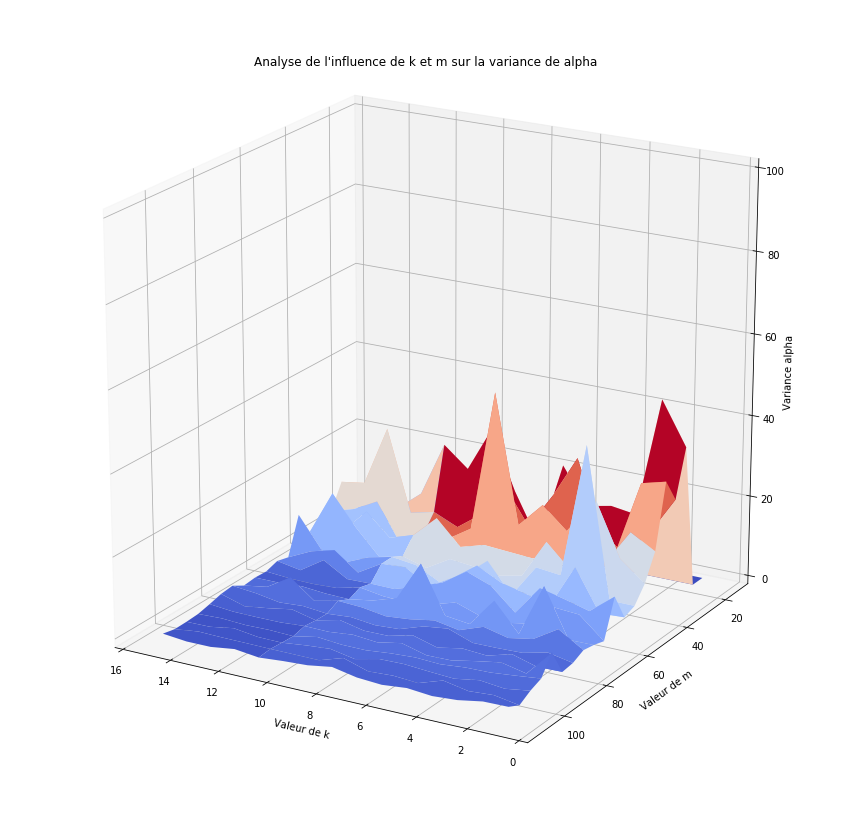

In [34]:
plot_3D(x, y, Mat_a, "alpha")

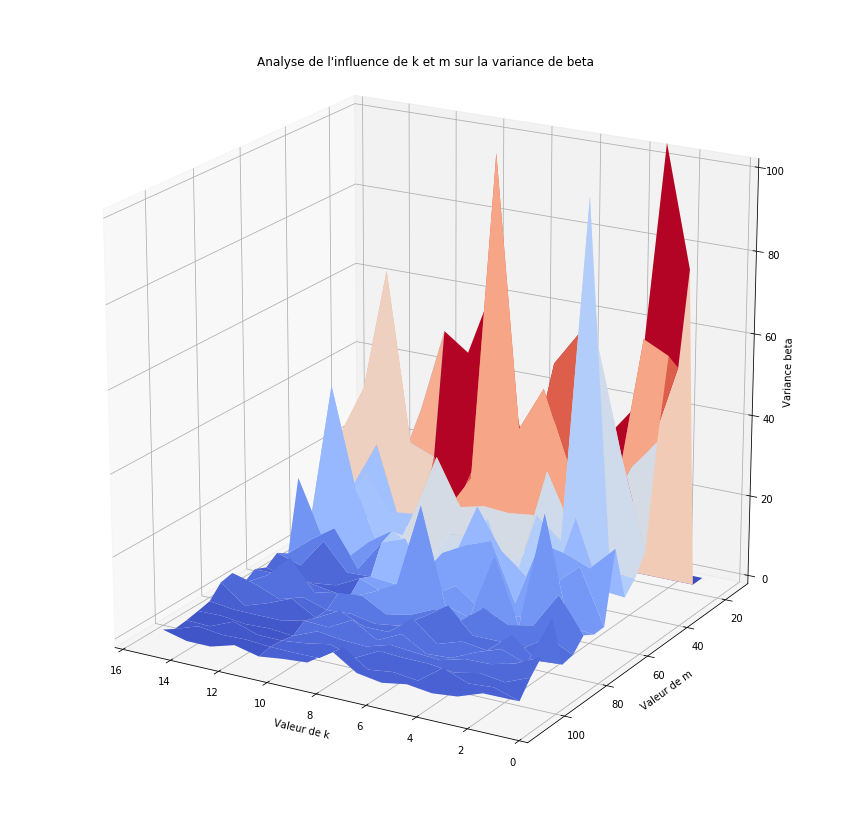

In [35]:
plot_3D(x, y, Mat_b, "beta")

Plusieurs éléments sont à remarquer ici.

Premièrement, le code pour ces graphiqus comprend est assez difficile compte tenu de problèmes d'indices. En revanche, d'autres calculs menés en parallèle ont montré que les résultats présentés étaient corrects. 
Nous avons fait le choix de privilégier le graphique en 3D plutôt que de multiples graphiques 2D empilés car ces derniers auraient été illisibles.

Par ailleurs, si l'on se concentre sur alpha (l'analyse concernant beta est similaire), nous observons que sa variance est très élevée pour des valeurs faibles de m et ce, quelle que soit la valeur de k. En revanche, lorsque m augmente, la variance diminue nettement, et d'autant plus lorsque k est supérieur ou égal à 12. Au total, dès que la valeur de m dépasse 40, on constate que la variance approche 0. Enfin, on remarque que la variance de beta est nettement plus élevée comparée à celle d'alpha.

On retrouve donc bien ici les résultats esquissés dans la section 2.3, puis démontrés dans la section 3.1 : à mesure que k et m augmentent (plus précisément, lorsque k et m - k sont grands), la correction du biais tend vers 0 car $P(\tau<k)$ tend vers 1 on se rapproche de la variance d'une longue MCMC.

# Sources

* https://statisfaction.wordpress.com/2017/09/06/sampling-from-a-maximal-coupling/
* https://datasciencechalktalk.com/2019/09/22/understanding-rejection-sampling-method/
* https://colcarroll.github.io/couplings/
* https://www.youtube.com/watch?v=rxImfvwpWLA